# LibraryThings Recommendation System

This notebook contains the common data preprocessing used for all our approaches.


## 1. Loading reviews.txt

In [127]:
import ast
import pickle
import re

from gensim.models import Word2Vec
from matplotlib import pyplot as plt 
import networkx as nx
import numpy as np
import nltk
# Uncomment for first run
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()


We begin by importing the dataset. The dataset can be downloaded from https://cseweb.ucsd.edu//~jmcauley/datasets.html#social_data. The following code assumes that the files are placed in the same directory as this notebook. 

A few blocks that load/dump the data are commented. These need to be uncommented when run for the first time. These can be later be commented again for subsequent runs to save time.

In [2]:
# Uncomment to run the first time.


# review_list = []
# with open('reviews.txt', 'r') as f:
#     for line in f:
#         if line == 'reviews = {}\n':
#             continue
#         try:
#             _, review = line.split(')] = ')
#             review_list.append(ast.literal_eval(review))
#         except:
#             print(line)
#             break

In [3]:
# review_list

Pickling for future use to avoid preprocessing the data again.

In [4]:
# Uncomment for the first time.

# with open('review_list.pkl', 'wb') as f:
#     pickle.dump(review_list, f)

In [6]:
with open('review_list.pkl', 'rb') as f:
    review_list = pickle.load(f)

In [7]:
reviews_df = pd.DataFrame(review_list)

In [8]:
reviews_df

,comment,nhelpful,unixtime,work,flags,user,stars,time
0,"Every evening, the brave queen of Persia, Shah...",0,1.332288e+09,73960,[],Elizabeth.Wong98,4.5,"Mar 21, 2012"
1,Its the 1983-84 school year and Edward Zanni o...,0,1.253405e+09,69413,[],rivkat,3.0,"Sep 20, 2009"
2,"I became privy to this book, when another auth...",0,1.299888e+09,9523995,[],suz.haugland,4.0,"Mar 12, 2011"
3,.,0,1.327277e+09,368228,[],amoskovacs,4.0,"Jan 23, 2012"
4,This is a tremendous story of a freed woman an...,0,1.329005e+09,11243828,[],CandyH,4.0,"Feb 12, 2012"
...,...,...,...,...,...,...,...,...
1707065,This is quite possibly the cutest kids book I'...,0,1.327795e+09,129503,[],evementen,NaN,"Jan 29, 2012"
1707066,This is a fairy tale which is very much a Cupi...,0,1.364688e+09,11749693,[],AmyMacEvilly,5.0,"Mar 31, 2013"
1707067,http://tamaranth.blogspot.com/1994/03/guilty-p...,0,1.176682e+09,4873693,[],tamaranth,4.5,"Apr 16, 2007"
1707068,Despus del extraordinario xito de Los ojos ama...,0,1.321920e+09,9705446,[],bibliosa,NaN,"Nov 22, 2011"


## 2. Understanding the data

Looking at the data, we have the following columns:
* comment: User review/comments about the book
* nhelpful: Number of users who found the review/comment helpful
* unixtime: UNIX time when review/comment was submitted
* work: Book identifier
* flags: Can be from the following values: \['', 'not_a_review', 'abuse'\]
* user: Username
* stars: Ratings on a scale of 5
* time: Date when review was submitted

Based on the following, it seems that *unixtime* and *time* represent the same, and are therefore redundant.

In [9]:
reviews_df.isna().sum()

comment          0
nhelpful         0
unixtime        90
work             0
flags            0
user             0
stars       319861
time            90
dtype: int64

We see that there are some entries with null values. We will be dropping these entries.

In [10]:
reviews_df.dropna(inplace=True)

In [11]:
reviews_df.isna().sum()

comment     0
nhelpful    0
unixtime    0
work        0
flags       0
user        0
stars       0
time        0
dtype: int64

### Unpacking flags list

Since the *'flags'* attribute contains lists which are unhashable, we cannot identify duplicate rows. We need to convert *'flags'* into a separate feature.

In [12]:
reviews_df['flags'].apply(lambda x: tuple(_ for _ in x) if x else ()).unique()

array([(), ('not_a_review',), ('abuse',), ('abuse', 'not_a_review')],
      dtype=object)

We see that there are 3 possible flag values: {'', 'not_a_review', 'abuse'}. These flags can also be combined.

In [13]:
reviews_df['abuse'] = reviews_df['flags'].apply(lambda x: 'abuse' in x)

In [14]:
reviews_df['not_a_review'] = reviews_df['flags'].apply(lambda x: 'not_a_review' in x)

We can safely drop the 'flags' attribute.

In [15]:
reviews_df.drop('flags', axis = 1, inplace=True)

First, let's take a look at entries flagged as 'not_a_review'

In [16]:
reviews_df[reviews_df['not_a_review']]

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review
55,"A disturbing book, but one that I can recommend.",0,1.169251e+09,1199218,writestuff,4.0,"Jan 20, 2007",False,True
193,"USA, ca 1984.\nHovedpersonen William Halleck k...",0,1.226794e+09,35834,bnielsen,4.0,"Nov 16, 2008",False,True
434,I loved this book -- Corey Sifter is a likeabl...,0,1.237507e+09,69759,stephaniechase,3.0,"Mar 20, 2009",False,True
639,http://en.wikipedia.org/wiki/The_Glenn_Miller_...,0,1.282435e+09,11528316,wdjoyner,4.0,"Aug 22, 2010",True,True
689,Listen/read my review here - http://alchemyofs...,0,1.311206e+09,11010126,nownewstrue,4.0,"Jul 21, 2011",False,True
...,...,...,...,...,...,...,...,...,...
1706781,"CWE founded 1881, pub 1st ed 1885, see entry, ...",0,1.269475e+09,9734301,kitchengardenbooks,4.0,"Mar 25, 2010",False,True
1706856,I included this book in my book: The 100 Best ...,0,1.241741e+09,7605,toddsattersten,5.0,"May 8, 2009",True,True
1706889,http://bookchronicle.wordpress.com/2007/10/19/...,0,1.223338e+09,1488,bookchronicle,4.0,"Oct 7, 2008",False,True
1707030,Setting: United StatesReview? Maybe later or m...,0,1.282522e+09,522063,thereshegoes,4.0,"Aug 23, 2010",False,True


Let's look at a few 'not_a_review' flagged entries

In [17]:
reviews_df.loc[55].comment

'A disturbing book, but one that I can recommend. '

In [18]:
reviews_df.loc[193].comment

'USA, ca 1984.\nHovedpersonen William Halleck krer en sigjnerkvinde over. Han kender politimesteren og dommeren og gr fri. Lige p nr en forbandelse: "Tyndere". Hvert kapitel starter med et tal for hans vgt og det gr kun nedad. Han har det ok med at tabe sig, men ikke i et konstant uafvendeligt tempo.\nSigjneren forbander ogs dommeren og politimesteren.\nSigjnernes forbandelser er p svensk, hvilket er ret morsomt. Side 240: "Han satte sig pa en av stolarna! Han sneglade pa nytt mot hyllorna i vild! Vild!" Halleck kender en barsk type, som truer sigjneren til at give Halleck en chance for at slippe for forbandelsen ved at give den videre.\nMen det gr ogs galt og han ender med at tage en god portion af forbandelsen selv.\nNydelig Stephen King roman hvor en helt almindelig person pludselig sidder i en skruestik '

Following is the translation from above: (generated using Google Translate)


'USA, circa 1984.\nThe main character William Halleck seduces a wealthy woman. He knows the chief of police and the judge and goes free. Right after a curse: "Thinner". Each chapter starts with a number for his weight and it only goes down. He's okay with losing weight, but not at a constant irreversible pace.\nThe signer also curses the judge and the police chief.\nThe signer's curses are in Swedish, which is quite funny. Page 240: "He sat down on one of the chairs! He slunk again towards the shelves wildly! Wildly!" Halleck knows a rough guy who threatens the signer to give Halleck a chance to escape the curse by passing it on.\nBut that also goes wrong and he ends up taking a good portion of the curse himself.\nLovely Stephen King novel where a completely ordinary person suddenly sits in a vise '



In [19]:
reviews_df.loc[434].comment

'I loved this book -- Corey Sifter is a likeable, believable character, and the story of the rise and fall of a local powerful family and a politician running for President was fascinating. Canin moves back and forth between the past and the present in a way that is never confusing, but rather gives credence to the central theme of the book: the we are often in the dark, even about those closest to us. '

LibraryThings says the following about the flags system:

`Important: Do not abuse this feature. "Not a review" is not intended for short reviews, poorly-written reviews or reviews you disagree with. Links to the reviewer's blog are also acceptable. "Abuse of terms of service" includes violations such as spam reviews and posting copyrighted material without permission. See the terms of service for more guidelines.`


Users can flag reviews as "Not a review" or "Abuse of terms of service". What I have gathered from discussions on https://www.librarything.com/ngroups/2862/Flaggers%21 is that reviews where people do not provide anything meaningful about the book, and simply pass comments are likely to be flagged as "Not a review". But this isn't always the case, as people get wrongly flagged. The website uses an appeal/counter-flag system. Abuse includes copy-pasting reviews from other sources.

Out of the three listed above, only the second one doesn't look like a review. Looking at a few more cases, the following are definitely not reviews.

In [20]:
reviews_df.loc[639]

comment         http://en.wikipedia.org/wiki/The_Glenn_Miller_...
nhelpful                                                        0
unixtime                                             1282435200.0
work                                                     11528316
user                                                     wdjoyner
stars                                                         4.0
time                                                 Aug 22, 2010
abuse                                                        True
not_a_review                                                 True
Name: 639, dtype: object

In [21]:
reviews_df.loc[639].comment

'http://en.wikipedia.org/wiki/The_Glenn_Miller_Story '

In [22]:
reviews_df.loc[1707052].comment

'5Q 4P The "quote": Section III, the 6th double-page spread, where he is looking for food, and the food people show him seems so strange ... and he can\'t find a loaf of bread. '

With these entries being only a little over 1%, we can drop them safely. It is true that we might lose some legit review in the process.

In [23]:
19750/reviews_df.shape[0]

0.014238082364603047

Now, let's look at the abuse flagged items.

In [24]:
reviews_df[reviews_df['abuse']]

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review
143,Children's Literature - Lois Rubin Gross \nAn ...,0,1.316045e+09,8176470,EBurggraf,4.0,"Sep 15, 2011",True,False
633,Reviewed by Marta Morrison for TeensReadToo.co...,0,1.302394e+09,10886889,GeniusJen,5.0,"Apr 10, 2011",True,False
639,http://en.wikipedia.org/wiki/The_Glenn_Miller_...,0,1.282435e+09,11528316,wdjoyner,4.0,"Aug 22, 2010",True,True
1132,The only up-to-date anthology of traditional A...,0,1.196381e+09,3340171,butterfly3,4.0,"Nov 30, 2007",True,False
1147,"I decided to read this book, because the topic...",0,1.307664e+09,7997468,Princetonbookreview,4.0,"Jun 10, 2011",True,False
...,...,...,...,...,...,...,...,...,...
1703962,"Reviewer:\tG. Merritt (Boulder, CO) - See all ...",0,1.138752e+09,32389,gnewfry,5.0,"Feb 1, 2006",True,False
1704292,Reviewed by Jaglvr for TeensReadToo.com\n1989 ...,0,1.292026e+09,9900705,GeniusJen,5.0,"Dec 11, 2010",True,False
1704347,Wikipedia: The Rise and Fall of the Third Reic...,0,1.159402e+09,3038,billyfantles,5.0,"Sep 28, 2006",True,True
1704374,Reviewed by Carrie Spellman for TeensReadToo.c...,0,1.255392e+09,3576179,GeniusJen,5.0,"Oct 13, 2009",True,False


In [25]:
reviews_df.loc[1147].comment

'I decided to read this book, because the topic is unusual and I was intrigued by the Renaissance era. The backdrop for this book is a convent in the late 1500s. This is excellent well-researched Historical Fiction with great insight into convent life during this time period. Its fascinating and disturbing to realize that at one time women were forced into the convent because their families had only enough money for one dowry or they were disfigured or simply not pretty enough. In this story, Serafina enters the convent against her will because she refuses to marry the man he father chooses for her. Shes young, rebellious and determined to escape, which adds a layer of mystery to the story as you wonder if she will succeed. On a deeper level this book explores the hierarchy of female leadership in a closed all female society.\nReview previously posted at: www.princetonbookreview.com\nFind us on Face book http://www.facebook.com/#%21/pages/Princeton-Book-Review/73532562757 '

The above review abuses the TOS of LibraryThings. While the review provides us the details about the book, it doesn't convey the user's thoughts. We will therefore drop these entries.

In [26]:
new_review_df = reviews_df[reviews_df['not_a_review'] == False]

In [27]:
new_review_df = new_review_df[new_review_df['abuse'] == False]

To confirm the drop operation was successful:

In [28]:
new_review_df[new_review_df['abuse']]

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review


In [29]:
new_review_df[new_review_df['not_a_review']]

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review


### 2.1 Duplicate samples

In [30]:
new_review_df[new_review_df.duplicated()]

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review


It seems that there are no duplictes.

### 2.3 stars
We see that all ratings are between 0 and 5, with increments of 0.5.

In [31]:
new_review_df['stars'].unique()

array([4.5, 3. , 4. , 2. , 3.5, 5. , 1. , 2.5, 0.5, 1.5])

### 2.4 nhelpful

In [32]:
new_review_df['nhelpful'].unique()

array([  0,   6,   2,   1,   5,   7,   3,   4,  16,  22,  12,  18,  11,
        21,  13,  10,   9,   8,  47,  20,  30,  33,  15,  19,  28,  37,
        31,  23,  14,  26,  17,  36,  25,  72,  52,  27,  34,  58,  48,
        24,  63,  79,  32,  38, 129,  75,  29,  46, 332, 108,  40,  87,
        39,  68, 189,  59, 152, 100,  66,  44,  82,  41,  78,  45,  60,
        43, 316,  49,  76,  70,  77,  55,  67,  74])

In [33]:
new_review_df['nhelpful'].value_counts()

0     1200302
1      116734
2       25950
3        9046
4        3947
       ...   
63          1
52          1
72          1
47          1
74          1
Name: nhelpful, Length: 74, dtype: int64

It seems that most users never mark reviews as helpful. Let's try understanding the distribution:

<Axes: >

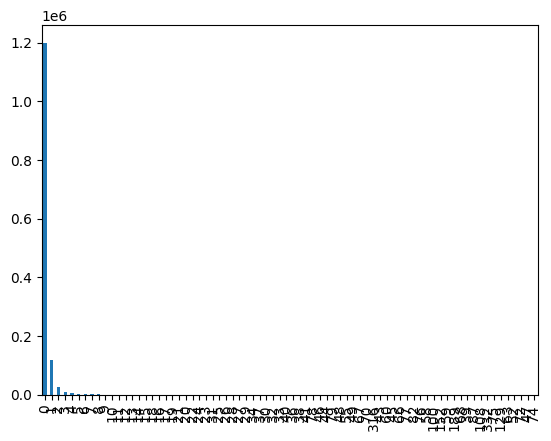

In [34]:
new_review_df['nhelpful'].value_counts().plot(kind='bar')

This is expected as most books are not a popular. People may therefore never read the reviews for these books and hence never find the reviews helpful.

### 2.5 comment

We see that there are a few comments with URLs. We need to clean these to ensure proper embeddings.

In [35]:
new_review_df[new_review_df['comment'].str.contains('http|www')]

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review
11,Monitor life.\nhttp://freesf.strandedinoz.com/...,0,1.309910e+09,11162023,BlueTysonSS,3.5,"Jul 6, 2011",False,False
12,You enter the moment of the naked lunch when y...,6,1.286150e+09,5852,funkendub,5.0,"Oct 4, 2010",False,False
14,"In these days of Echelon, Satellite spying, an...",1,1.169856e+09,1472,bluetyson,5.0,"Jan 27, 2007",False,False
29,C'est pour moi une premire exprience avec l'au...,0,1.365034e+09,8311485,Moncoinlecture,3.0,"Apr 4, 2013",False,False
61,Review posted here: http://offbeatvagabond.blo...,1,1.336090e+09,11357432,harleyquinn0887,5.0,"May 4, 2012",False,False
...,...,...,...,...,...,...,...,...,...
1706975,http://boekenwijs.blogspot.com/2008/05/heart-o...,0,1.210464e+09,2575,boekenwijs,2.0,"May 11, 2008",False,False
1706999,http://nwhyte.livejournal.com/1700514.html\nHe...,0,1.302307e+09,1411914,nwhyte,3.5,"Apr 9, 2011",False,False
1707039,http://library.tom-hanna.org/2007/margaret-lob...,0,1.189037e+09,35552,tomhanna,4.0,"Sep 6, 2007",False,False
1707063,http://olvasonaplo.freeblog.hu/archives/2007/0...,0,1.209082e+09,76280,sorsha,3.0,"Apr 25, 2008",False,False


In [36]:
# Percentage reviews with containing 'http' or 'www'

83321/new_review_df.shape[0]

0.06111221129374143

6% is not a large fraction of the total reviews.

In [37]:
# URL not guaranteed to contain with 'http'.
new_review_df[new_review_df['comment'].str.contains(' www')]

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review
12,You enter the moment of the naked lunch when y...,6,1.286150e+09,5852,funkendub,5.0,"Oct 4, 2010",False,False
162,It's a real shame for Monica Pradhan that AMy ...,0,1.321488e+09,2411376,bookczuk,3.0,"Nov 17, 2011",False,False
451,"What is it like... to be considered: ""Genius?""...",0,1.224634e+09,5787763,ANovelMenagerie,4.0,"Oct 22, 2008",False,False
1084,I received this book through www.librarything....,0,1.323216e+09,11357953,apsing01,4.0,"Dec 7, 2011",False,False
3025,Richard Powers is a master of sleight-of-hand....,0,1.286150e+09,8274047,funkendub,5.0,"Oct 4, 2010",False,False
...,...,...,...,...,...,...,...,...,...
1703742,"Nel silenzio della campagna pugliese, in un'es...",1,1.179619e+09,5950304,Streghissima,5.0,"May 20, 2007",False,False
1704179,"I bought this from Amazon at random, as I have...",0,1.360368e+09,11160219,nina.jon,4.0,"Feb 9, 2013",False,False
1705436,"In current day India, the police have called i...",0,1.301616e+09,9819803,Nickelini,4.0,"Apr 1, 2011",False,False
1705511,From the writers of the website www.gofugyours...,0,1.364688e+09,4792292,JenJ.,4.0,"Mar 31, 2013",False,False


In [38]:
new_review_df['comment'].loc[1084]

"I received this book through www.librarything.com and it's early reviewer's program. I really didn't know what to expect when I received this ebook. I started the book yesterday and finished it in one day. It was very engaging. The characters were interesting and the story was fast-paced. There were parts that were thrilling, especially the beginning. The off the wall antics of Brian help lighten the story. I enjoyed traveling along with Brenda and Brian, especially the dinner with the parents scene. I wish that it had been a little longer because I'm dying to know what happens next. The ending is a bit of a cliffhanger. Yes, they solved the immediate issue with the criminal at hand but who were those other people and what do they want? I really do think that this book is a great one. The author really knows how to make people laugh at the sheer craziness of the book. \nhttp://letthemalleatcake.blogspot.com/2011/12/medium-dead-by-chris-dolley.html "

We need to remove the URLs and use the remaining text as part of reviews. Also need to clean up any special characters, and handle escape sequences.

In [39]:
comments = new_review_df['comment'].copy()

In [40]:
comments

0          Every evening, the brave queen of Persia, Shah...
1          Its the 1983-84 school year and Edward Zanni o...
2          I became privy to this book, when another auth...
3                                                      .    
4          This is a tremendous story of a freed woman an...
                                 ...                        
1707063    http://olvasonaplo.freeblog.hu/archives/2007/0...
1707064    I came to this book with low expectations. The...
1707066    This is a fairy tale which is very much a Cupi...
1707067    http://tamaranth.blogspot.com/1994/03/guilty-p...
1707069    I originally met most of the diseases covered ...
Name: comment, Length: 1363410, dtype: object

#### 2.5.1 Clean URLs

We can remove the URLs using regex. Below are some examples of how it works:

In [41]:
comments[1707067]

'http://tamaranth.blogspot.com/1994/03/guilty-pleasures-laurell-k-hamilton.html '

In [42]:
re.sub('https?://[\S]+|www\.[\S]+', '',
       'http://tamaranth.blogspot.com/1994/03/guilty-pleasures-laurell-k-hamilton.html ')

' '

In [43]:
re.sub('https?://[\S]+|www\.[\S]+',
       '',
       """I received this book through www.librarything.com and it's early reviewer's program. I really didn't know what to expect when I received this ebook. I started the book yesterday and finished it in one day. It was very engaging. The characters were interesting and the story was fast-paced. There were parts that were thrilling, especially the beginning. The off the wall antics of Brian help lighten the story. I enjoyed traveling along with Brenda and Brian, especially the dinner with the parents scene. I wish that it had been a little longer because I'm dying to know what happens next. The ending is a bit of a cliffhanger. Yes, they solved the immediate issue with the criminal at hand but who were those other people and what do they want? I really do think that this book is a great one. The author really knows how to make people laugh at the sheer craziness of the book. \nhttp://letthemalleatcake.blogspot.com/2011/12/medium-dead-by-chris-dolley.html 

""")

"I received this book through  and it's early reviewer's program. I really didn't know what to expect when I received this ebook. I started the book yesterday and finished it in one day. It was very engaging. The characters were interesting and the story was fast-paced. There were parts that were thrilling, especially the beginning. The off the wall antics of Brian help lighten the story. I enjoyed traveling along with Brenda and Brian, especially the dinner with the parents scene. I wish that it had been a little longer because I'm dying to know what happens next. The ending is a bit of a cliffhanger. Yes, they solved the immediate issue with the criminal at hand but who were those other people and what do they want? I really do think that this book is a great one. The author really knows how to make people laugh at the sheer craziness of the book. \n \n\n"

In [44]:
tmp = comments.str.replace('https?://[\S]+|www\.[\S]+', '', regex = True)

In [45]:
tmp

0          Every evening, the brave queen of Persia, Shah...
1          Its the 1983-84 school year and Edward Zanni o...
2          I became privy to this book, when another auth...
3                                                      .    
4          This is a tremendous story of a freed woman an...
                                 ...                        
1707063                                                     
1707064    I came to this book with low expectations. The...
1707066    This is a fairy tale which is very much a Cupi...
1707067                                                     
1707069    I originally met most of the diseases covered ...
Name: comment, Length: 1363410, dtype: object

In [46]:
tmp[tmp.str.contains('http')]

205267     Very emotional, but beautifully balanced novel...
221947         http:/bactra.org/reviews/christensen-kiefer/ 
251469     You've read this story before. It's the story ...
310864     Morozovs excellent first book, The Net Delusio...
407371     Through the Triangle\nC.P. Stewart\nOutskirts ...
466105     James I is not a familiar king to me and curio...
498466     The promises, and a few perils, of stacks of d...
567626     The first thing any reader needs to know about...
576673     http:/bactra.org/reviews/manski-on-identificat...
612623     I am going to be frank. Very frank.\nSomeone t...
763775     Comme souvent chez Graham Greene on retrouve d...
922110     4 STARS\nWas entertaining but not to the point...
959484     Ashley Z. "Staying Fat for Sarah Byrnes." (9 J...
971974     When we meet Bud Caldwell, he is living in an ...
1190298    It took me a long time to get around to readin...
1206870    http:// \nAn academic, Paulos writes text that...
1303036    Num estilo ou

While we see some obvious invalid URLs due to user errors, a some are confusing. Let's look at the below examples.

In [47]:
tmp[1206870]

'http:// \nAn academic, Paulos writes text that is easy to read. He writes very openly about his large loss on WorldCom stock.\nA few quotes:\n"Transparency, trust, independence, and authority are all needed to make accounting work. They are all in great demand, but sometimes in short supply."\n"On the whole, most investors, professionals on Wall Street, amateurs everywhere, disbelieve (the Efficient Market Hypothesis), so for this reason I think it holds, but only approximately and only most of the time."\n"For better or worse, we\'re on our own." '

In [48]:
comments[1206870]

'http:// www.math.temple.edu/paulos\nAn academic, Paulos writes text that is easy to read. He writes very openly about his large loss on WorldCom stock.\nA few quotes:\n"Transparency, trust, independence, and authority are all needed to make accounting work. They are all in great demand, but sometimes in short supply."\n"On the whole, most investors, professionals on Wall Street, amateurs everywhere, disbelieve (the Efficient Market Hypothesis), so for this reason I think it holds, but only approximately and only most of the time."\n"For better or worse, we\'re on our own." '

It seems that the user mistakenly introduced a space between 'http://' and 'www'. We can fix these issues manually as we only have a handful of entries.

In [49]:
tmp[576673]

'http:/bactra.org/reviews/manski-on-identification/ '

In [50]:
comments[1489388]

'http//:www.estampa.pt '

In [51]:
tmp[1489388]

'http//: '

In [52]:
tmp1 = tmp.str.replace('https?://[\S]*|https?:/[\S]+|https?//:[\S]*|https?/:[\S]*|http:', '', regex = True)

As we can see below, the remaining entries only contain http as part of the content.

In [53]:
tmp1[tmp1.str.contains('http')]

205267    Very emotional, but beautifully balanced novel...
310864    Morozovs excellent first book, The Net Delusio...
971974    When we meet Bud Caldwell, he is living in an ...
Name: comment, dtype: object

In [54]:
tmp[310864]

'Morozovs excellent first book, The Net Delusion, established him as a major critic of internet eschatology, particularly the utopian brand. His latest book attempts to expand on that critique, sometimes successfully and sometimes not. (Insert joke about sophomore efforts and snark here.) For a sample mostly taken from the book, heres Morozov on why we shouldnt be sanguine about using technology to improve incarceration. A good sampling of Morozovs work is available online; I would recommend avoiding his debate with Farhad Manjoo in Slate, where Morozov mostly ignores legitimate hits (he attacks generalizations like the internet but himself has no trouble criticizing Silicon Valley) in favor of snide near-ad hominems.\nMorozov wouldnt be surprised that I, as an internet reviewer (ordinary people dont write reviews for the same reasons as professional critics; they are mostly interested in reviewing their own experience, not in making sense of a given work), cant improve on Kevin Drisco

In [55]:
tmp[971974]

'When we meet Bud Caldwell, he is living in an orphanage in Flint, Michigan. Soon, though, we find him on the lam and in search of his father whom he has never met. He always carries his few belongings in a suitcase, and in the suitcase are clues his dead mother left behind about his father. This hope of escaping the abuses of foster care and orphan life propels him onward as he searches for his long lost, unknown father. The story is set during the Great Depression, at a time when little black boys are not permitted where "white folks" are permitted. The story bridges the gaps in cultural differences by using the authentic voice of a typical young boy who is struggling to be grown but is still a frightened young man. In the story he has gone through so much and yet keeps his cynical sense of humor about him.\nI think this book is an excellent multicultural read for persons of all ages. The ISSUES are not overstated and do not take from the story. Many young readers will feel smarter t

In [56]:
tmp[tmp.str.contains(' www\.')]

Series([], Name: comment, dtype: object)

#### 2.5.2 Convert the text to embeddings

We initially tried translate all comments to English. This was time consuming and I would hit the API rate limits, leading to connection timedout errors.

In [61]:
# Only for information. Do not uncomment/run this cell.

# from googletrans import Translator
# translator = Translator()

In [64]:
# Only for information. Do not uncomment/run this cell.

# translated_tmp = tmp.apply(translator.translate, dest='en').apply(getattr, args=('text',))

ProtocolError: Invalid input ConnectionInputs.RECV_PING in state ConnectionState.CLOSED

Instead, we opted to remove any entries that did not contain English comments. We use the nltk's English stopwords list to identify comments with atleast one stopword. Comments that do not contain a single stopword are dropped.

In [57]:
tmp = tmp.str.lower()

In [58]:
stop_words_set = set(stopwords.words('english'))

In [59]:
visited = set()

def remove_stopwords(text, idx):
    words = re.sub('\s', ' ', text)
    words = re.sub('\W', ' ', text).split()
    filtered = []
    seen = False
    for i in words:
        if i not in stop_words_set:
            filtered.append(i)
        else:
            #stopword encountered => English
            if not seen:
                # Add to visited
                visited.add(idx)
                seen = True
    return filtered

tmp_org = tmp.copy()
for i in tqdm(tmp.index):
    if type(tmp.loc[i]) == str:
        tmp.loc[i] = remove_stopwords(tmp.loc[i], i)

  0%|          | 0/1363410 [00:00<?, ?it/s]

Let's see the number of comments with English stopwords. We can assume that these are all the comments in English.

In [60]:
len(visited)

1304956

We can now filter the English comments

In [61]:
tmp = tmp[sorted(visited)]

In [62]:
tmp.shape

(1304956,)

In [63]:
tmp

0          [every, evening, brave, queen, persia, shahraz...
1          [1983, 84, school, year, edward, zanni, hoboke...
2          [became, privy, book, another, author, enjoy, ...
4          [tremendous, story, freed, woman, family, sold...
5          [book, officially, caught, series, unfortunate...
                                 ...                        
1707061    [chess, still, lot, messed, head, still, drugs...
1707062    [could, wait, get, started, book, entertaining...
1707064    [came, book, low, expectations, reputation, au...
1707066    [fairy, tale, much, cupid, amp, psyche, beauty...
1707069    [originally, met, diseases, covered, book, med...
Name: comment, Length: 1304956, dtype: object

Let's ensure that we are not left with any empty reviews.

In [64]:
tmp = tmp[tmp.str.len() != 0]

In [65]:
tmp.shape

(1304851,)

Seems like there were a few empty reviews. To reduce the number of words in the corpus I am using the Snowball Stemmer.

In [66]:
SnowballStemmer("english").stem("generously")

'generous'

This might take a while (~15 minutes). Thanks to tqdm we can atleast see the progress.

In [67]:
stemmer = SnowballStemmer("english")
stem_tmp = tmp.progress_apply(lambda x: [stemmer.stem(i) for i in x])

  0%|          | 0/1304851 [00:00<?, ?it/s]

With that done, we are now ready to create word embeddings. This might take a while (~10 min).

In [68]:
model = Word2Vec(sentences=stem_tmp, workers=8)

In [69]:
model.corpus_total_words

109827776

In [70]:
# deleting a few temporary variables to free up memory.
del tmp, comments, visited, review_list

In [71]:
model.save("word2vec.model")

In [72]:
stem_tmp

0          [everi, even, brave, queen, persia, shahrazad,...
1          [1983, 84, school, year, edward, zanni, hoboke...
2          [becam, privi, book, anoth, author, enjoy, rea...
4          [tremend, stori, freed, woman, famili, sold, s...
5          [book, offici, caught, seri, unfortun, one, wa...
                                 ...                        
1707061    [chess, still, lot, mess, head, still, drug, t...
1707062    [could, wait, get, start, book, entertain, fel...
1707064    [came, book, low, expect, reput, author, drew,...
1707066    [fairi, tale, much, cupid, amp, psych, beauti,...
1707069    [origin, met, diseas, cover, book, medic, scho...
Name: comment, Length: 1304851, dtype: object

A sample word embedding looks as follows.

In [74]:
model.wv['hello']

array([ 0.10367627, -0.36851317,  2.908397  ,  0.76862586,  2.3114858 ,
        0.77372485,  1.2550653 , -1.0869534 , -1.6220549 , -0.8652857 ,
       -0.41185504, -0.04806287, -0.08261371,  0.89254326, -0.7953942 ,
        0.70350254,  0.14092682, -1.4167191 ,  0.32493967, -0.90796095,
        1.1187738 ,  0.2959407 ,  3.569652  ,  0.23005548,  0.59086347,
        0.06128922,  0.18929835, -0.63353115, -0.35106736,  2.0770605 ,
       -0.5452487 , -0.1359947 ,  2.145128  , -1.2206489 , -0.35350963,
        1.5968848 ,  0.44131425,  1.8023636 , -0.6034191 , -2.002628  ,
       -1.0121001 ,  0.94772446,  0.45991266, -0.8703325 , -0.06479299,
        0.80011874, -0.9967619 ,  0.78014034,  0.9306472 ,  1.6344388 ,
        0.51528007,  0.03724037, -0.5539777 ,  0.11597644,  0.43016955,
       -0.14809838, -1.1131036 , -0.35874802, -1.1808735 , -1.2574525 ,
       -2.360807  , -1.5821738 ,  1.2406336 , -1.2765911 , -1.2988397 ,
       -4.5440154 , -1.0999631 ,  0.31808326, -0.47380888, -1.18

To create sentence embeddings, we simply add together the word embeddings for each word in the sentence.

In [75]:
def create_embedding(text):
    embedding = np.zeros(100)
    for i in text:
        try:
            embedding += model.wv[i]
        except:
            pass
    return embedding

In [76]:
comment_embedding = stem_tmp.progress_apply(lambda x: create_embedding(x))

  0%|          | 0/1304851 [00:00<?, ?it/s]

In [77]:
comment_embedding.shape

(1304851,)

In [78]:
comment_embedding[0].shape

(100,)

Saving the embeddings for later use.

In [79]:
with open('comment_embedding.pkl', 'wb') as f:
    pickle.dump(comment_embedding, f)

In [80]:
with open('comment_embedding.pkl', 'rb') as f:
    comment_embedding = pickle.load(f)

Create a new dataframe with embeddeded comments.

In [81]:
filtered_df = new_review_df.loc[comment_embedding.index]

Drop unnecessary columns.

In [82]:
filtered_df.drop(['comment', 'abuse', 'not_a_review'], axis=1, inplace=True)

In [83]:
filtered_df['comment_embedding'] = comment_embedding

Clear up some memory

In [84]:
del new_review_df

In [85]:
filtered_df

,nhelpful,unixtime,work,user,stars,time,comment_embedding
0,0,1.332288e+09,73960,Elizabeth.Wong98,4.5,"Mar 21, 2012","[2.5197164304554462, 9.239733213093132, 146.32..."
1,0,1.253405e+09,69413,rivkat,3.0,"Sep 20, 2009","[-14.71329341083765, 25.712940784171224, 48.76..."
2,0,1.299888e+09,9523995,suz.haugland,4.0,"Mar 12, 2011","[-38.33073106780648, -76.95045654382557, 380.8..."
4,0,1.329005e+09,11243828,CandyH,4.0,"Feb 12, 2012","[-1.175795417279005, -20.05130848288536, 54.44..."
5,0,1.278893e+09,9071901,miyurose,2.0,"Jul 12, 2010","[-13.733905084431171, -20.63186874985695, 50.9..."
...,...,...,...,...,...,...,...
1707061,0,1.373242e+09,11234213,wyvernfriend,3.5,"Jul 8, 2013","[-7.426372528076172, -15.056323887780309, 113...."
1707062,0,1.330906e+09,87328,bookwormteri,2.0,"Mar 5, 2012","[-3.401369333267212, -12.215308649465442, 87.7..."
1707064,0,1.314230e+09,11633344,TheLogo,4.5,"Aug 25, 2011","[-160.51695234514773, -31.787006503902376, 270..."
1707066,0,1.364688e+09,11749693,AmyMacEvilly,5.0,"Mar 31, 2013","[12.153995676431805, -40.83596940524876, 46.27..."


It seems that we have a few unique UNIX timestamps

In [86]:
filtered_df.unixtime.unique().shape

(2918,)

We can drop 'time' as it is redundant.

In [87]:
filtered_df.drop(['time'], axis=1, inplace=True)

In [88]:
filtered_df.head()

,nhelpful,unixtime,work,user,stars,comment_embedding
0,0,1.332288e+09,73960,Elizabeth.Wong98,4.5,"[2.5197164304554462, 9.239733213093132, 146.32..."
1,0,1.253405e+09,69413,rivkat,3.0,"[-14.71329341083765, 25.712940784171224, 48.76..."
2,0,1.299888e+09,9523995,suz.haugland,4.0,"[-38.33073106780648, -76.95045654382557, 380.8..."
4,0,1.329005e+09,11243828,CandyH,4.0,"[-1.175795417279005, -20.05130848288536, 54.44..."
5,0,1.278893e+09,9071901,miyurose,2.0,"[-13.733905084431171, -20.63186874985695, 50.9..."


In [89]:
filtered_df.user.unique().shape

(67414,)

In [90]:
with open('filtered_df.pkl', 'wb') as f:
    pickle.dump(filtered_df, f)

In [91]:
with open('filtered_df.pkl', 'rb') as f:
    filtered_df = pickle.load(f)

Now, let's create an adjacency matrix using the graph data. We begin by creating integer identifiers for each user

In [92]:
user_to_index = {}
for i, user in enumerate(filtered_df.user.unique()):
    user_to_index[user] = i

In [93]:
user_to_index

{'Elizabeth.Wong98': 0,
 'rivkat': 1,
 'suz.haugland': 2,
 'CandyH': 3,
 'miyurose': 4,
 'melissaconway': 5,
 'mab2008': 6,
 'agnesmack': 7,
 'funkendub': 8,
 'notmyrealname': 9,
 'bluetyson': 10,
 'Kristelh': 11,
 'ebruno': 12,
 'judithrs': 13,
 'Jaie22': 14,
 'ronda73ca': 15,
 'AmandaThon': 16,
 'JoClare': 17,
 'annajamieson': 18,
 'Marlyn': 19,
 'TadAD': 20,
 'Moncoinlecture': 21,
 'bermudaonion': 22,
 'klarsenmd': 23,
 'bjmitch': 24,
 'SamuelW': 25,
 'quilted_kat': 26,
 'RachDan': 27,
 'jhibburt': 28,
 'Lavinient': 29,
 'lizzielou': 30,
 'isiswardrobe': 31,
 'branadain': 32,
 'roxy': 33,
 'voltn74': 34,
 'rhonda1111': 35,
 'krau0098': 36,
 'McEvilla': 37,
 'samfsmith': 38,
 'zenosbooks': 39,
 'Readingfanatic1': 40,
 'ntempest': 41,
 'kakadoo202': 42,
 'Ixachel': 43,
 'Karlstar': 44,
 'polarbear123': 45,
 'harleyquinn0887': 46,
 'lesleydawn': 47,
 'nwhyte': 48,
 'jburlinson': 49,
 'Isamoor': 50,
 'sprowett': 51,
 'schnaucl': 52,
 'jewelknits': 53,
 'the_nimue': 54,
 'sacredheart25':

Import the graph data.

In [94]:
edges = pd.read_csv('edges.txt', sep=' ', header=None)

In [95]:
num_users = filtered_df.user.unique().shape[0]

In [96]:
adjacency_matrix = np.zeros([num_users, num_users])

In [97]:
adjacency_matrix.shape

(67414, 67414)

Adjacency Matrix

In [98]:
for i, j in edges.values[:5]:
    print(i, j)

Rodo anehan
Rodo sevilemar
Rodo dingsi
Rodo slash
RelaxedReader AnnRig


In [99]:
for i, j in edges.values:
    u, v = user_to_index[i], user_to_index[j]
    adjacency_matrix[u][v] = adjacency_matrix[v][u] = 1

KeyError: 'anehan'

In [100]:
'anehan' in filtered_df.user

False

It seems that there not all users are common in the two datasets. Let's identify the common users and drop the entries for all other users.

In [101]:
df_users = set(filtered_df.user)
edges_users = set(pd.concat([edges[0], edges[1]]))

In [102]:
len(df_users.intersection(edges_users))

25275

In [103]:
common_users = df_users.intersection(edges_users)

In [104]:
new_filtered_df = filtered_df[filtered_df.user.isin(common_users)]

In [105]:
new_filtered_df.shape

(938898, 6)

In [106]:
with open('new_filtered_df.pkl', 'wb') as f:
    pickle.dump(new_filtered_df, f)

In [107]:
with open('new_filtered_df.pkl', 'rb') as f:
    new_filtered_df = pickle.load(f)

In [108]:
new_filtered_df

,nhelpful,unixtime,work,user,stars,comment_embedding
0,0,1.332288e+09,73960,Elizabeth.Wong98,4.5,"[2.5197164304554462, 9.239733213093132, 146.32..."
1,0,1.253405e+09,69413,rivkat,3.0,"[-14.71329341083765, 25.712940784171224, 48.76..."
2,0,1.299888e+09,9523995,suz.haugland,4.0,"[-38.33073106780648, -76.95045654382557, 380.8..."
4,0,1.329005e+09,11243828,CandyH,4.0,"[-1.175795417279005, -20.05130848288536, 54.44..."
5,0,1.278893e+09,9071901,miyurose,2.0,"[-13.733905084431171, -20.63186874985695, 50.9..."
...,...,...,...,...,...,...
1707060,0,1.248048e+09,2129329,heidijane,4.0,"[-5.322856396436691, -0.9089336022734642, 15.1..."
1707061,0,1.373242e+09,11234213,wyvernfriend,3.5,"[-7.426372528076172, -15.056323887780309, 113...."
1707062,0,1.330906e+09,87328,bookwormteri,2.0,"[-3.401369333267212, -12.215308649465442, 87.7..."
1707066,0,1.364688e+09,11749693,AmyMacEvilly,5.0,"[12.153995676431805, -40.83596940524876, 46.27..."


We recalculate the integer indices for each username and create a smaller adjacency matrix.

In [109]:
user_to_index = {}
for i, user in enumerate(common_users):
    user_to_index[user] = i

In [110]:
adjacency_matrix = np.zeros([len(common_users), len(common_users)])

In [111]:
for i, j in edges.values:
    if i in common_users and j in common_users:
        u, v = user_to_index[i], user_to_index[j]
        adjacency_matrix[u][v] = adjacency_matrix[v][u] = 1

In [112]:
adjacency_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [113]:
adjacency_matrix.shape

(25275, 25275)

In [114]:
with open('adjacency_matrix.pkl', 'wb') as f:
    pickle.dump(adjacency_matrix, f)

In [115]:
with open('adjacency_matrix.pkl', 'rb') as f:
    adjacency_matrix = pickle.load(f)

Due to the large size of the adjacency matrix, it cannot be used directly as a feature.

In [119]:
new_filtered_df.head()

,nhelpful,unixtime,work,user,stars,comment_embedding
0,0,1.332288e+09,73960,Elizabeth.Wong98,4.5,"[2.5197164304554462, 9.239733213093132, 146.32..."
1,0,1.253405e+09,69413,rivkat,3.0,"[-14.71329341083765, 25.712940784171224, 48.76..."
2,0,1.299888e+09,9523995,suz.haugland,4.0,"[-38.33073106780648, -76.95045654382557, 380.8..."
4,0,1.329005e+09,11243828,CandyH,4.0,"[-1.175795417279005, -20.05130848288536, 54.44..."
5,0,1.278893e+09,9071901,miyurose,2.0,"[-13.733905084431171, -20.63186874985695, 50.9..."


## 3. Graph dataset

Contributed by Martin

Let's look at graph data in more detail. We begin by retaining only the common users.

In [122]:
edges = edges[edges[0].isin(common_users)]
edges = edges[edges[1].isin(common_users)]

In [125]:
edges.drop_duplicates(inplace=True)

In [126]:
edges.shape

(99706, 2)

In [129]:
G = nx.Graph()
G.add_nodes_from(common_users)
for i, j in edges.values:
    if i in common_users and j in common_users:
        G.add_edge(i,j)

In [130]:
len(G.edges)

63187

In [131]:
nx.is_connected(G)

False

We can see that the graph is disconnected. Let's look at the connected components in the graph.

In [134]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G_m = G.subgraph(Gcc[0])
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[18161,
 68,
 56,
 54,
 46,
 41,
 24,
 17,
 17,
 16,
 15,
 14,
 13,
 12,
 12,
 12,
 12,
 11,
 10,
 10,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 

We see that most of the users are part of a single connected component. We will be using this largest connected component for our analysis.

In [135]:
len(set(G_m.nodes).intersection(common_users))

18161